In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import json

In [18]:
df_cost_categorized = pd.read_csv("Hospital_Inpatient_Cost_Transparency_Categorized.csv")
print(df_cost_categorized["Categorization"].unique())
df_cost_categorized.head(20)

['Cardiac Conditions' 'Other' 'Cancer-Related Conditions'
 'Neurological Disorders' 'Trauma & Injury' 'Respiratory Conditions'
 'Digestive Disorders' 'Musculoskeletal Disorders'
 'Endocrine & Metabolic Disorders' 'Delivery and Neonatal Procedures'
 'Infectious Diseases']


,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost,Categorization
0,2016,4,Albany Memorial Hospital,194,1,Heart Failure,Minor,M,Medical,2,8375.41,8375.41,3585.05,3585.05,Cardiac Conditions
1,2016,4,Albany Memorial Hospital,194,2,Heart Failure,Moderate,M,Medical,40,14029.82,12176.95,6182.67,5253.15,Cardiac Conditions
2,2016,4,Albany Memorial Hospital,194,3,Heart Failure,Major,M,Medical,70,23921.77,20229.81,11149.49,9068.10,Cardiac Conditions
3,2016,4,Albany Memorial Hospital,194,4,Heart Failure,Extreme,M,Medical,12,51260.45,35210.82,26081.70,15230.62,Cardiac Conditions
4,2016,4,Albany Memorial Hospital,196,4,Cardiac Arrest,Extreme,M,Medical,1,25357.84,25357.84,7791.75,7791.75,Cardiac Conditions
5,2016,4,Albany Memorial Hospital,226,1,Anal Procedures,Minor,P,Surgical,1,19519.24,19519.24,7533.43,7533.43,Other
6,2016,4,Albany Memorial Hospital,251,3,Abdominal Pain,Major,M,Medical,1,9918.48,9918.48,3734.21,3734.21,Other
7,2016,4,Albany Memorial Hospital,302,1,Knee Joint Replacement,Minor,P,Surgical,1,32689.13,32689.13,15429.94,15429.94,Other
8,2016,4,Albany Memorial Hospital,302,2,Knee Joint Replacement,Moderate,P,Surgical,1,25748.61,25748.61,12709.99,12709.99,Other
9,2016,325,Alice Hyde Medical Center,240,3,Digestive Malignancy,Major,M,Medical,1,29896.31,29896.31,10302.89,10302.89,Cancer-Related Conditions


In [19]:
df_cost_categorized.head()


,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost,Categorization
0,2016,4,Albany Memorial Hospital,194,1,Heart Failure,Minor,M,Medical,2,8375.41,8375.41,3585.05,3585.05,Cardiac Conditions
1,2016,4,Albany Memorial Hospital,194,2,Heart Failure,Moderate,M,Medical,40,14029.82,12176.95,6182.67,5253.15,Cardiac Conditions
2,2016,4,Albany Memorial Hospital,194,3,Heart Failure,Major,M,Medical,70,23921.77,20229.81,11149.49,9068.10,Cardiac Conditions
3,2016,4,Albany Memorial Hospital,194,4,Heart Failure,Extreme,M,Medical,12,51260.45,35210.82,26081.70,15230.62,Cardiac Conditions
4,2016,4,Albany Memorial Hospital,196,4,Cardiac Arrest,Extreme,M,Medical,1,25357.84,25357.84,7791.75,7791.75,Cardiac Conditions


In [20]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'Hospital_Inpatient_Cost_Transparency_Categorized.csv'
df_cost_categorized = pd.read_csv(file_path)

def create_z_score_list(df):
    # First, calculate statistics across all hospitals for each condition and severity
    stats_by_condition = {}
    
    # Calculate mean and std for each condition and severity level
    for condition in df['Categorization'].unique():
        condition_data = df[df['Categorization'] == condition]
        stats_by_condition[condition] = {}
        
        for severity in ['1', '2', '3', '4']:
            severity_data = condition_data[condition_data['APR Severity of Illness Code'] == int(severity)]
            
            if not severity_data.empty:
                costs = severity_data['Median Cost']
                mean = costs.mean()
                std = costs.std()
                
                stats_by_condition[condition][severity] = {
                    'mean': mean,
                    'std': std
                }

    # Now create the dictionary to store z-scores for each hospital
    hospitals_z_scores = {}

    for facility_id in df['Facility Id'].unique():
        facility_data = df[df['Facility Id'] == facility_id]
        basic_info = facility_data.iloc[0]
        
        hospitals_z_scores[float(facility_id)] = {
            'name': basic_info['Facility Name'],
            'condition_cost_stats': {}
        }

        for condition in facility_data['Categorization'].unique():
            condition_data = facility_data[facility_data['Categorization'] == condition]
            
            hospitals_z_scores[facility_id]['condition_cost_stats'][condition] = {}

            for severity in ['1', '2', '3', '4']:
                severity_data = condition_data[
                    condition_data['APR Severity of Illness Code'] == int(severity)
                ]
                
                if not severity_data.empty:
                    median_cost = severity_data['Median Cost'].iloc[0]
                    stats = stats_by_condition[condition][severity]
                    
                    # Calculate z-score
                    z_score = (median_cost - stats['mean']) / stats['std'] if stats['std'] != 0 else 0
                    
                    hospitals_z_scores[facility_id]['condition_cost_stats'][condition][severity] = z_score
                else:
                    hospitals_z_scores[facility_id]['condition_cost_stats'][condition][severity] = None
    
    return hospitals_z_scores

def rank_costs_by_condition_severity(hospitals_z_scores):
    # Create a dictionary to store the rankings for each condition and severity
    ranked_costs = {}

    # Iterate over each condition and severity to rank hospitals based on their z-scores
    for facility_id, hospital_data in hospitals_z_scores.items():
        for condition, condition_data in hospital_data['condition_cost_stats'].items():
            z_scores = {severity: score for severity, score in condition_data.items() if score is not None}
            
            # Normalize z-scores across all hospitals for the current condition and severity
            if z_scores:
                # Find the min and max z-scores for normalization
                min_z_score = min(z_scores.values())
                max_z_score = max(z_scores.values())
                
                # Normalize z-scores to 0-100
                for severity, z_score in z_scores.items():
                    normalized_score = max(0, min(100, 100 - ((z_score - min_z_score) / (max_z_score - min_z_score) * 100)))
                    
                    # Add the normalized z-score to the final ranking dictionary
                    if facility_id not in ranked_costs:
                        ranked_costs[facility_id] = {
                            'name': hospital_data['name'],
                            'condition_cost_stats': {}
                        }
                    
                    if condition not in ranked_costs[facility_id]['condition_cost_stats']:
                        ranked_costs[facility_id]['condition_cost_stats'][condition] = {}
                    
                    ranked_costs[facility_id]['condition_cost_stats'][condition][severity] = {
                        'z_score': z_score,
                        'normalized_score': round(normalized_score, 2)
                    }

    return ranked_costs

# Create the z-scores list
hospital_z_scores = create_z_score_list(df_cost_categorized)

# Rank the costs by condition and severity
ranked_hospitals = rank_costs_by_condition_severity(hospital_z_scores)

print(ranked_hospitals)


{4.0: {'name': 'Albany Memorial Hospital', 'condition_cost_stats': {'Cardiac Conditions': {'1': {'z_score': -0.4789372435485324, 'normalized_score': 67.66}, '2': {'z_score': -0.5220665277562984, 'normalized_score': 100}, '3': {'z_score': -0.4035172061881551, 'normalized_score': 11.12}, '4': {'z_score': -0.38868734457063836, 'normalized_score': 0}}, 'Other': {'1': {'z_score': -0.05174074857488094, 'normalized_score': 70.7}, '2': {'z_score': 0.030276027558832908, 'normalized_score': 65.43}, '3': {'z_score': -0.5078131688092217, 'normalized_score': 100}, '4': {'z_score': 1.0485875193885634, 'normalized_score': 0}}, 'Neurological Disorders': {'1': {'z_score': -0.17978386197273383, 'normalized_score': 100}, '2': {'z_score': 0.5709543660518464, 'normalized_score': 77.08}, '3': {'z_score': 0.22407166834516248, 'normalized_score': 87.67}, '4': {'z_score': 3.0960497869687917, 'normalized_score': 0}}, 'Cancer-Related Conditions': {'1': {'z_score': -0.45029776303969676, 'normalized_score': 88.67}

/var/folders/fq/6j5vjdy13w36prs570mvsk300000gn/T/ipykernel_79450/1006628304.py:83: RuntimeWarning: invalid value encountered in scalar divide
  normalized_score = max(0, min(100, 100 - ((z_score - min_z_score) / (max_z_score - min_z_score) * 100)))


In [21]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'Hospital_Inpatient_Cost_Transparency_Categorized.csv'
df_cost_categorized = pd.read_csv(file_path)

def create_z_score_list(df):
    # First, calculate statistics across all hospitals for each condition (not by severity)
    stats_by_condition = {}
    
    # Calculate mean and std for each condition across all severities
    for condition in df['Categorization'].unique():
        condition_data = df[df['Categorization'] == condition]
        stats_by_condition[condition] = {}
        
        # Get the costs for all severities (combine them)
        costs = condition_data['Median Cost']
        mean = costs.mean()
        std = costs.std()
        
        stats_by_condition[condition] = {
            'mean': mean,
            'std': std
        }

    # Now create the dictionary to store z-scores for each hospital
    hospitals_z_scores = {}

    for facility_id in df['Facility Id'].unique():
        facility_data = df[df['Facility Id'] == facility_id]
        basic_info = facility_data.iloc[0]
        
        hospitals_z_scores[float(facility_id)] = {
            'name': basic_info['Facility Name'],
            'condition_cost_stats': {}
        }

        for condition in facility_data['Categorization'].unique():
            condition_data = facility_data[facility_data['Categorization'] == condition]
            
            hospitals_z_scores[facility_id]['condition_cost_stats'][condition] = {}

            # Calculate a single z-score for the condition based on the mean and std across severities
            median_costs = condition_data['Median Cost']
            stats = stats_by_condition[condition]
            
            # Calculate z-score for the entire condition (single value for all severities)
            z_score = (median_costs.iloc[0] - stats['mean']) / stats['std'] if stats['std'] != 0 else 0
            
            hospitals_z_scores[facility_id]['condition_cost_stats'][condition] = {
                'z_score': z_score
            }
    
    return hospitals_z_scores

def rank_costs_by_condition_severity(hospitals_z_scores):
    # Create a dictionary to store the rankings for each condition (not by severity)
    ranked_costs = {}

    # Calculate min and max z-scores across all hospitals for each condition
    condition_z_scores = {condition: [] for condition in set([condition for hospital in hospitals_z_scores.values() for condition in hospital['condition_cost_stats']])}

    # Collect all z-scores for each condition
    for facility_id, hospital_data in hospitals_z_scores.items():
        for condition, condition_data in hospital_data['condition_cost_stats'].items():
            z_score = condition_data['z_score']
            condition_z_scores[condition].append(z_score)

    # Normalize z-scores across all hospitals for each condition
    for facility_id, hospital_data in hospitals_z_scores.items():
        for condition, condition_data in hospital_data['condition_cost_stats'].items():
            z_score = condition_data['z_score']
            
            # Normalize the z-scores to a 0-100 scale for each condition
            z_scores = condition_z_scores[condition]
            min_z_score = min(z_scores)
            max_z_score = max(z_scores)
            
            # Normalize z-score
            normalized_score = 100 - ((z_score - min_z_score) / (max_z_score - min_z_score) * 100) if max_z_score - min_z_score != 0 else 0
            
            if facility_id not in ranked_costs:
                ranked_costs[facility_id] = {
                    'name': hospital_data['name'],
                    'condition_cost_stats': {}
                }
            
            ranked_costs[facility_id]['condition_cost_stats'][condition] = {
                'z_score': z_score,
                'normalized_score': round(normalized_score, 2)
            }

    return ranked_costs

# Create the z-scores list
hospital_z_scores = create_z_score_list(df_cost_categorized)

# Rank the costs by condition (not by severity)
ranked_hospitals = rank_costs_by_condition_severity(hospital_z_scores)

# Optionally, save the rankings to a JSON file
with open('hospital_rankings.json', 'w') as f:
    json.dump(ranked_hospitals, f, indent=2)


In [22]:
print(ranked_hospitals)

{4.0: {'name': 'Albany Memorial Hospital', 'condition_cost_stats': {'Cardiac Conditions': {'z_score': -0.6539560276483279, 'normalized_score': 98.97}, 'Other': {'z_score': -0.30715863833141627, 'normalized_score': 99.27}, 'Neurological Disorders': {'z_score': -0.5086125078267065, 'normalized_score': 96.93}, 'Cancer-Related Conditions': {'z_score': -0.40913016663745755, 'normalized_score': 95.6}, 'Infectious Diseases': {'z_score': -0.608363087448838, 'normalized_score': 95.42}, 'Trauma & Injury': {'z_score': -0.45056700628162866, 'normalized_score': 99.64}, 'Respiratory Conditions': {'z_score': -0.2631642873447232, 'normalized_score': 97.96}, 'Digestive Disorders': {'z_score': -0.4044665763448407, 'normalized_score': 96.81}, 'Musculoskeletal Disorders': {'z_score': -0.5775757614718336, 'normalized_score': 92.41}, 'Endocrine & Metabolic Disorders': {'z_score': -0.027962102287462244, 'normalized_score': 90.61}}}, 325.0: {'name': 'Alice Hyde Medical Center', 'condition_cost_stats': {'Cance

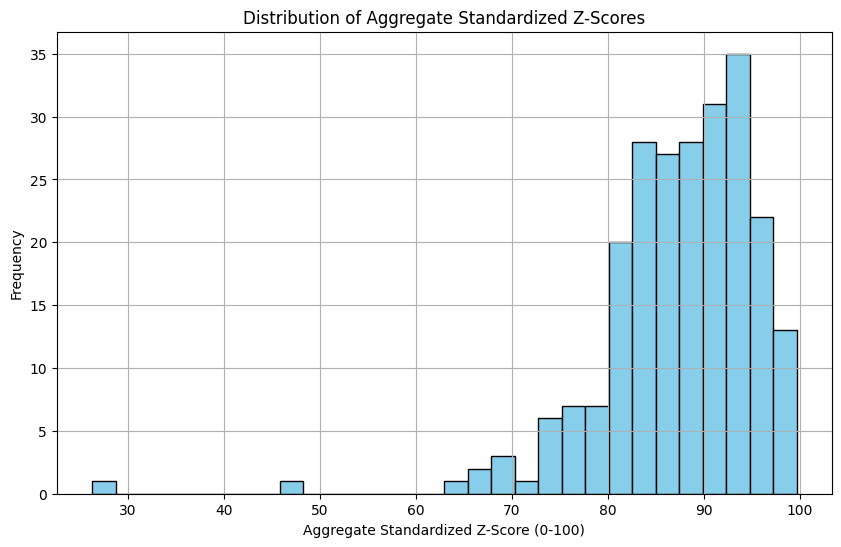

In [23]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file containing hospital data
df_cost_categorized = pd.read_csv('Hospital_Inpatient_Cost_Transparency_Categorized.csv')

# Step 1: Calculate statistics across all hospitals for each condition category
def create_z_score_list_by_category(df):
    stats_by_condition = {}
    
    # Calculate mean and std for each condition and severity level
    for condition in df['Categorization'].unique():
        condition_data = df[df['Categorization'] == condition]
        stats_by_condition[condition] = {}
        
        for severity in ['1', '2', '3', '4']:
            severity_data = condition_data[condition_data['APR Severity of Illness Code'] == int(severity)]
            
            if not severity_data.empty:
                costs = severity_data['Median Cost']
                mean = costs.mean()
                std = costs.std()
                
                stats_by_condition[condition][severity] = {
                    'mean': mean,
                    'std': std
                }

    hospitals_z_scores = {}

    for facility_id in df['Facility Id'].unique():
        facility_data = df[df['Facility Id'] == facility_id]
        basic_info = facility_data.iloc[0]
        
        hospitals_z_scores[float(facility_id)] = {
            'name': basic_info['Facility Name'],
            'z_scores_by_condition': {}
        }

        for condition in facility_data['Categorization'].unique():
            condition_data = facility_data[facility_data['Categorization'] == condition]
            
            hospitals_z_scores[facility_id]['z_scores_by_condition'][condition] = {}

            z_scores_for_condition = []
            
            # For each severity, calculate the z-score
            for severity in ['1', '2', '3', '4']:
                severity_data = condition_data[
                    condition_data['APR Severity of Illness Code'] == int(severity)
                ]
                
                if not severity_data.empty:
                    median_cost = severity_data['Median Cost'].iloc[0]
                    stats = stats_by_condition[condition][severity]
                    
                    # Calculate z-score
                    z_score = (median_cost - stats['mean']) / stats['std'] if stats['std'] != 0 else 0
                    
                    z_scores_for_condition.append(z_score)
                    hospitals_z_scores[facility_id]['z_scores_by_condition'][condition][severity] = z_score
                else:
                    hospitals_z_scores[facility_id]['z_scores_by_condition'][condition][severity] = None
            
            # Calculate the average z-score for the condition
            if z_scores_for_condition:
                average_z_score = np.mean(z_scores_for_condition)
                hospitals_z_scores[facility_id]['z_scores_by_condition'][condition]['average_z_score'] = average_z_score
    
    return hospitals_z_scores

# Create the z-scores list
hospital_z_scores = create_z_score_list_by_category(df_cost_categorized)

# Step 2: Normalize the z-scores by condition category and calculate the aggregate normalized cost score
def rank_hospitals_by_category(hospital_z_scores):
    ranked_hospitals = {}
    
    for facility_id, hospital_data in hospital_z_scores.items():
        ranked_hospitals[facility_id] = {
            'name': hospital_data['name'],
            'normalized_scores_by_condition': {},
            'aggregate_normalized_score': None  # To store the final aggregate score
        }
        
        all_normalized_scores = []
        
        for condition, condition_data in hospital_data['z_scores_by_condition'].items():
            # Get the average z-score for the condition
            hospital_z_score = condition_data['average_z_score']
            
            # Get the z-scores for the same condition across all hospitals
            z_scores_for_condition = []
            for other_facility_id, other_hospital_data in hospital_z_scores.items():
                if condition in other_hospital_data['z_scores_by_condition']:
                    other_z_score = other_hospital_data['z_scores_by_condition'][condition].get('average_z_score', None)
                    if other_z_score is not None:
                        z_scores_for_condition.append(other_z_score)
            
            # Calculate the min and max z-scores for normalization
            min_z_score = min(z_scores_for_condition)
            max_z_score = max(z_scores_for_condition)
            
            # Normalize the z-score for the current hospital for this condition
            if max_z_score != min_z_score:
                normalized_z_score = max(0, min(100, 100 - ((hospital_z_score - min_z_score) / (max_z_score - min_z_score) * 100)))
            else:
                normalized_z_score = 100  # If all z-scores are equal, give full score (100)
            
            ranked_hospitals[facility_id]['normalized_scores_by_condition'][condition] = normalized_z_score
            
            # Add the normalized score to the list for aggregate calculation
            all_normalized_scores.append(normalized_z_score)
        
        # Calculate the overall aggregate normalized score for the hospital
        if all_normalized_scores:
            aggregate_normalized_score = np.mean(all_normalized_scores)
            ranked_hospitals[facility_id]['aggregate_normalized_score'] = round(aggregate_normalized_score, 2)
    
    return ranked_hospitals

# Rank hospitals by their normalized z-scores and calculate the aggregate score
ranked_hospitals = rank_hospitals_by_category(hospital_z_scores)

# Optionally, save the rankings to a JSON file
with open('hospital_rankings_by_category.json', 'w') as f:
    json.dump(ranked_hospitals, f, indent=2)

def plot_aggregate_standardized_z_scores(ranked_hospitals):
    # Collect all aggregate normalized scores for the histogram
    all_aggregate_scores = []
    
    for facility_id, hospital_data in ranked_hospitals.items():
        aggregate_score = hospital_data.get('aggregate_normalized_score', None)
        if aggregate_score is not None:
            all_aggregate_scores.append(aggregate_score)
    
    # Plot the histogram of aggregate normalized z-scores
    plt.figure(figsize=(10, 6))
    plt.hist(all_aggregate_scores, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Aggregate Standardized Z-Scores')
    plt.xlabel('Aggregate Standardized Z-Score (0-100)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot the histogram of all aggregate standardized z-scores
plot_aggregate_standardized_z_scores(ranked_hospitals)


In [24]:
print(ranked_hospitals)

{4.0: {'name': 'Albany Memorial Hospital', 'normalized_scores_by_condition': {'Cardiac Conditions': 94.91659554412271, 'Other': 93.89160494762852, 'Neurological Disorders': 92.1114830627797, 'Cancer-Related Conditions': 90.24176855767425, 'Infectious Diseases': 91.47003238099063, 'Trauma & Injury': 97.74966609337689, 'Respiratory Conditions': 92.94776150181761, 'Digestive Disorders': 95.55945605366728, 'Musculoskeletal Disorders': 95.53060633725032, 'Endocrine & Metabolic Disorders': 86.62762529926293}, 'aggregate_normalized_score': 93.1}, 325.0: {'name': 'Alice Hyde Medical Center', 'normalized_scores_by_condition': {'Cancer-Related Conditions': 95.82600057849933, 'Other': 99.02072084471851, 'Delivery and Neonatal Procedures': 95.93372791495949, 'Neurological Disorders': 97.98417394344905, 'Trauma & Injury': 99.5200202566531, 'Respiratory Conditions': 99.35225633272081, 'Cardiac Conditions': 98.76568870828461, 'Digestive Disorders': 97.73806966248894, 'Musculoskeletal Disorders': 97.7

In [25]:
with open("final_costs_ny.json", "w+") as f:
    json.dump(ranked_hospitals, f)